In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
df=pd.read_csv('engineered_restaurant_dataset.csv')

In [38]:
df.shape

(9551, 26)

In [39]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [40]:
df_copy = df.copy()

In [41]:
df_copy[0:1]

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,Average Cost for two,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes,avg_cost_for_one,Cuisine Count,Cuisines_Mean_Rating,Cuisines_Mean_Rating_Avg,Price_TableBooking
0,6317637,Le Petit Souffle,162,Makati City,71,"Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"['French', 'Japanese', 'Desserts']",1100,Botswana Pula(P),1,0,0,0,3,4.8,5,5,314,3465.0,3,"[3.8620689655172415, 3.7985611510791366, 2.978...",3.546499,3


In [42]:
columns_to_drop=['Restaurant ID','Restaurant Name','City','Locality','Locality Verbose','Longitude','Latitude','Cuisines','Average Cost for two','Currency','Cuisines_Mean_Rating']

In [43]:
df_copy=df_copy.drop(columns=columns_to_drop)

In [44]:
df[['Country Code', 'Aggregate rating']].corr()

,Country Code,Aggregate rating
Country Code,1.000000,0.426419
Aggregate rating,0.426419,1.000000


<Axes: >

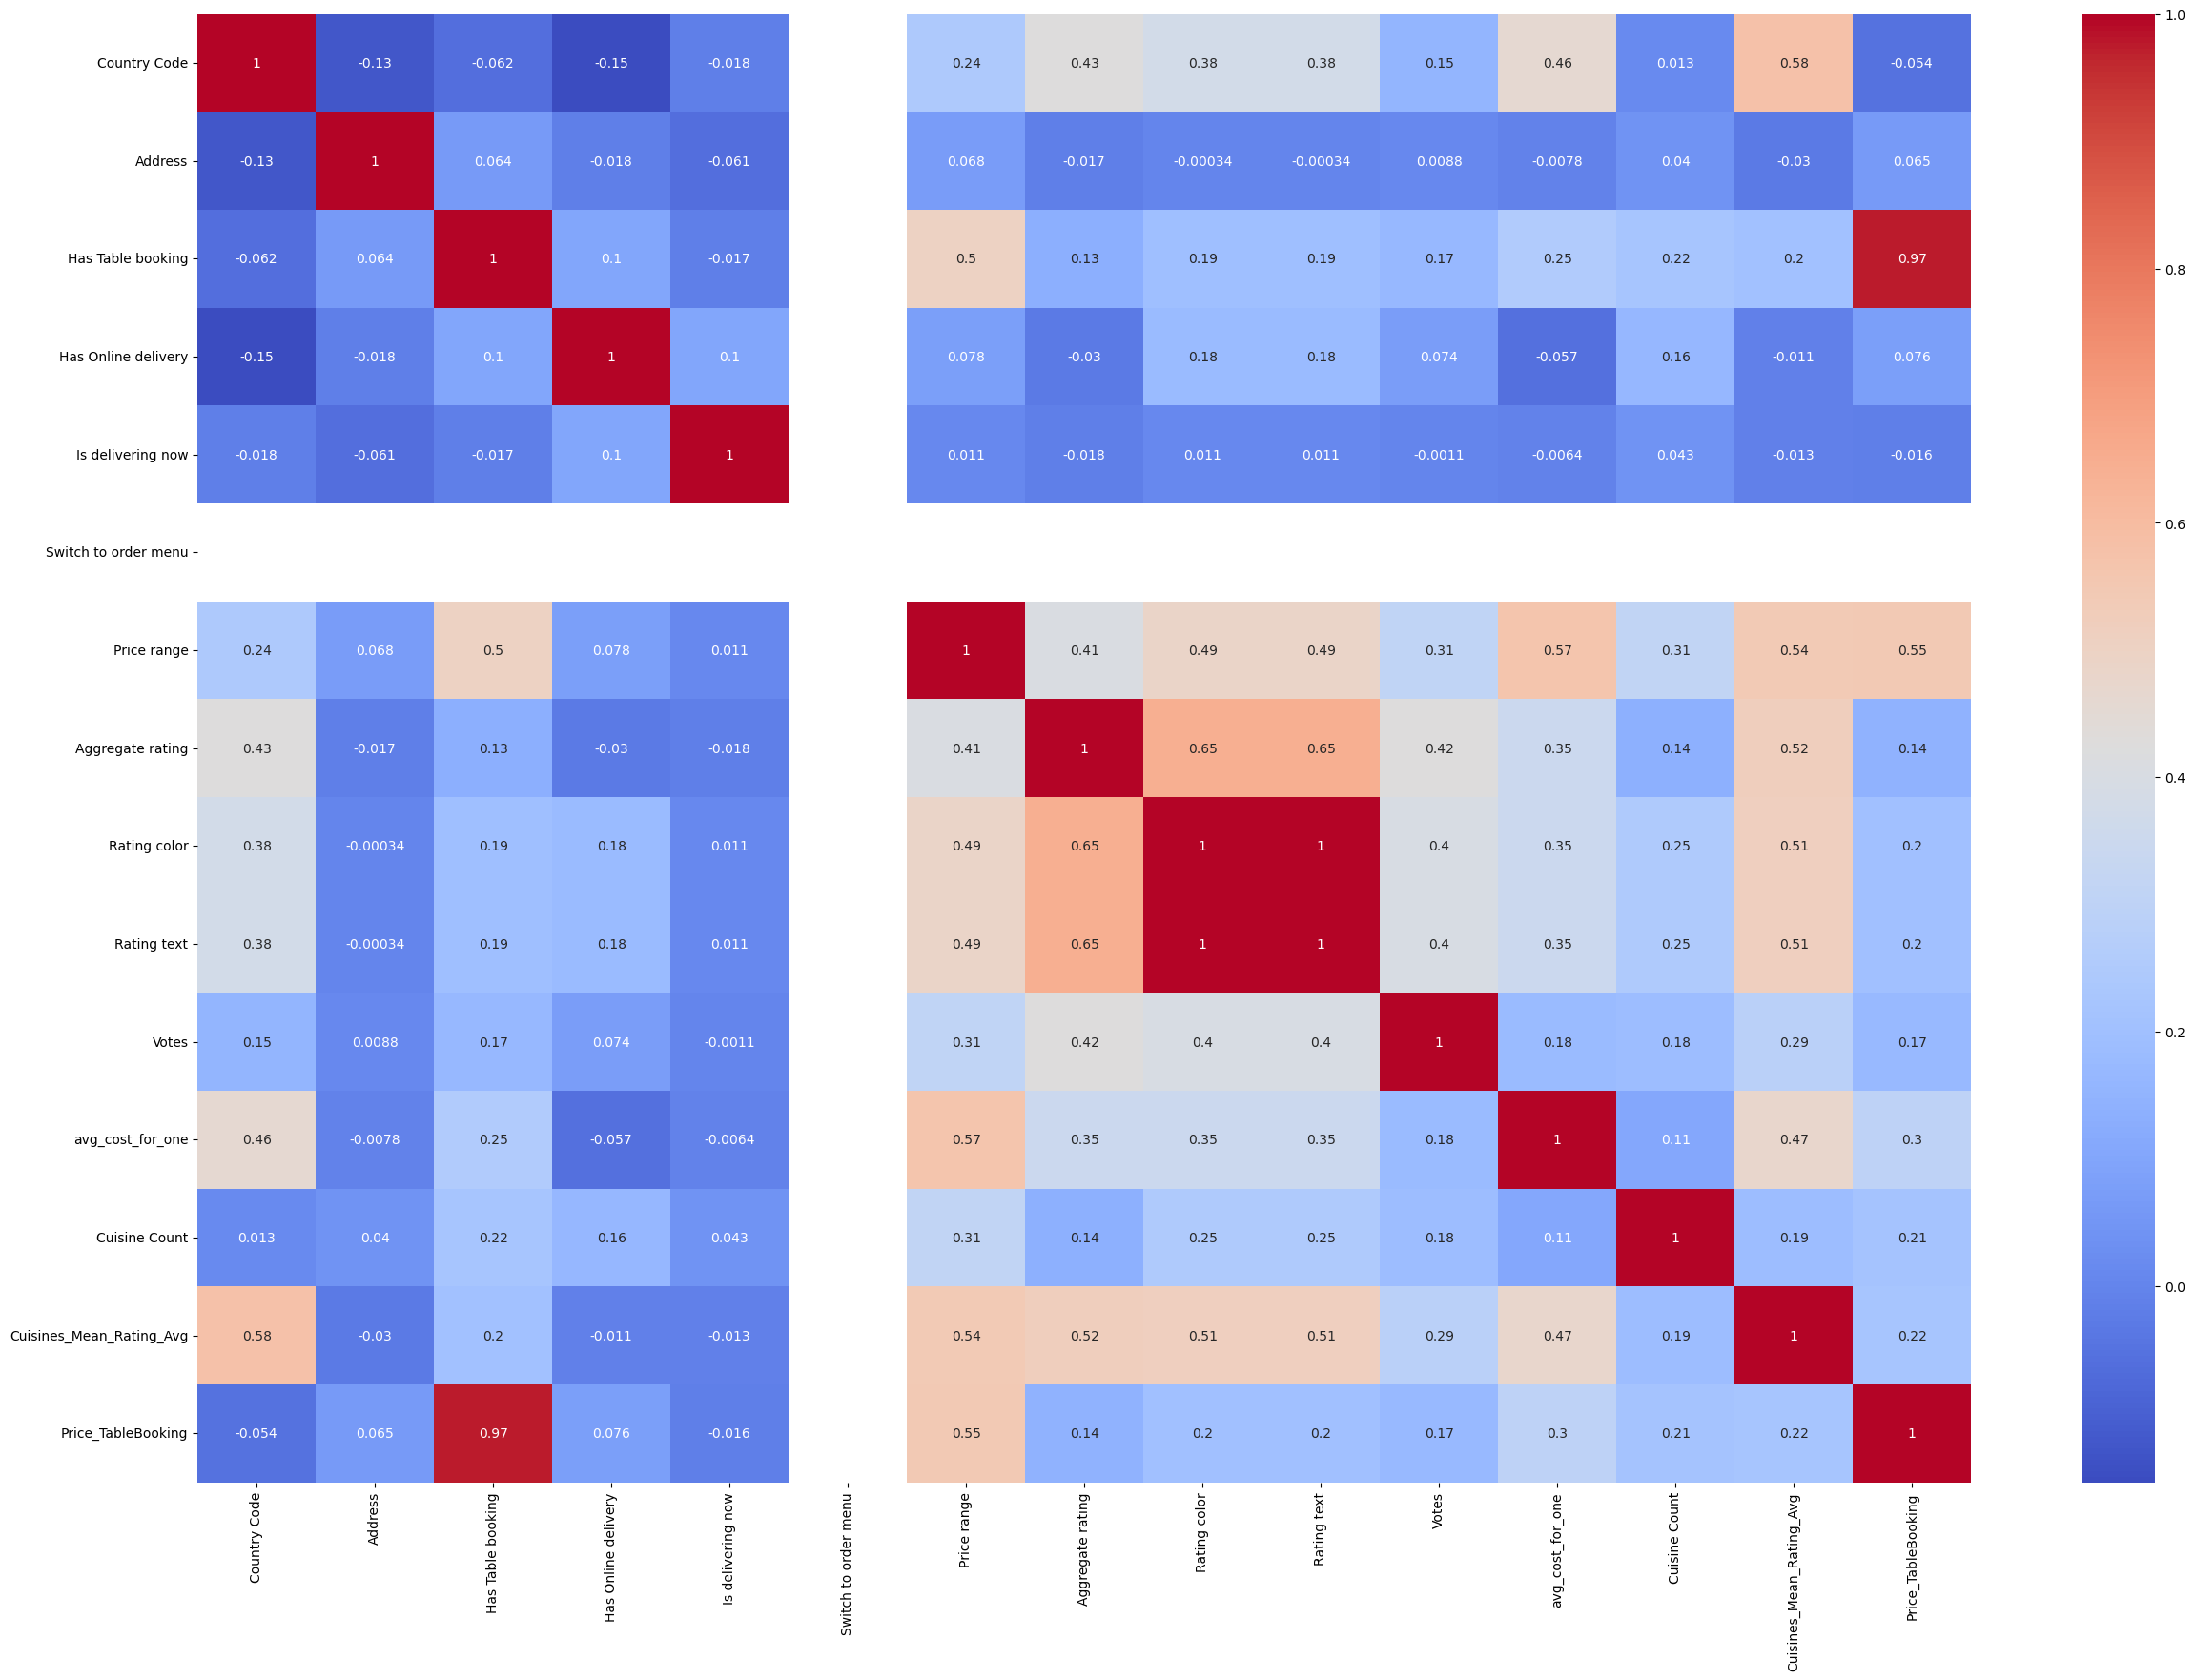

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 20))
### Here we are doing feature selection
# Technique 1 .Correlation analysis
sns.heatmap(df_copy.corr(),annot=True, cmap='coolwarm')

In [46]:
fi_df1 = df_copy.corr()['Aggregate rating'].iloc[1:].to_frame().reset_index().rename(columns={'index':'feature','Aggregate rating':'corr_coeff'})
fi_df1

,feature,corr_coeff
0,Address,-0.017252
1,Has Table booking,0.129637
2,Has Online delivery,-0.030251
3,Is delivering now,-0.018302
4,Switch to order menu,NaN
5,Price range,0.409049
6,Aggregate rating,1.000000
7,Rating color,0.645012
8,Rating text,0.645012
9,Votes,0.423723


In [47]:
X_label = df_copy.drop('Aggregate rating', axis=1)
y_label = df_copy['Aggregate rating']

In [48]:
#### Technique  2 random forest feature importance
from sklearn.ensemble import RandomForestRegressor

X_label.columns = X_label.columns.astype(str)

rf_label = RandomForestRegressor(n_estimators=100, random_state=42)
rf_label.fit(X_label, y_label)

fi_df2 = pd.DataFrame({
    'feature': X_label.columns,
    'rf_importance': rf_label.feature_importances_
}).sort_values(by='rf_importance', ascending=False)
fi_df2

,feature,rf_importance
7,Rating color,0.429092
8,Rating text,0.419228
9,Votes,0.053674
1,Address,0.033331
12,Cuisines_Mean_Rating_Avg,0.025217
10,avg_cost_for_one,0.019205
11,Cuisine Count,0.007750
3,Has Online delivery,0.003641
0,Country Code,0.003521
6,Price range,0.002785


In [49]:
# Gradient bossting for feature importance
from sklearn.ensemble import GradientBoostingRegressor

# Train a Random Forest regressor on label encoded data
gb_label = GradientBoostingRegressor()
gb_label.fit(X_label, y_label)

# Extract feature importance scores for label encoded data
fi_df3 = pd.DataFrame({
    'feature': X_label.columns,
    'gb_importance': gb_label.feature_importances_
}).sort_values(by='gb_importance', ascending=False)

fi_df3

,feature,gb_importance
7,Rating color,0.569745
8,Rating text,0.375142
9,Votes,0.043327
0,Country Code,0.003588
12,Cuisines_Mean_Rating_Avg,0.003564
10,avg_cost_for_one,0.001614
3,Has Online delivery,0.001060
1,Address,0.000978
11,Cuisine Count,0.000573
6,Price range,0.000221


In [50]:
# lasso regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_label)

# Train a LASSO regression model
lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_scaled, y_label)

# Extract coefficients
fi_df5 = pd.DataFrame({
    'feature': X_label.columns,
    'lasso_coeff': lasso.coef_
}).sort_values(by='lasso_coeff', ascending=False)

fi_df5


,feature,lasso_coeff
7,Rating color,2.206195e-01
9,Votes,8.221999e-02
12,Cuisines_Mean_Rating_Avg,7.339696e-02
0,Country Code,5.059178e-02
10,avg_cost_for_one,7.232191e-03
6,Price range,6.437109e-03
8,Rating text,1.934259e-17
1,Address,-0.000000e+00
2,Has Table booking,-0.000000e+00
4,Is delivering now,-0.000000e+00


In [51]:
from sklearn.feature_selection import RFE

# Initialize the base estimator
estimator = RandomForestRegressor()

selector_label = RFE(estimator, n_features_to_select=X_label.shape[1], step=1)
selector_label = selector_label.fit(X_label, y_label)

selected_features = X_label.columns[selector_label.support_]

selected_coefficients = selector_label.estimator_.feature_importances_

# Organize the results into a DataFrame
fi_df6 = pd.DataFrame({
    'feature': selected_features,
    'rfe_score': selected_coefficients
}).sort_values(by='rfe_score', ascending=False)

fi_df6

,feature,rfe_score
8,Rating text,0.426245
7,Rating color,0.416440
9,Votes,0.059006
1,Address,0.033486
12,Cuisines_Mean_Rating_Avg,0.025435
10,avg_cost_for_one,0.019139
11,Cuisine Count,0.007871
3,Has Online delivery,0.003678
0,Country Code,0.003441
6,Price range,0.002736


In [52]:
# Train a linear regression model on the label-encoded and standardized training data
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_scaled, y_label)

# Extract coefficients
fi_df7 = pd.DataFrame({
    'feature': X_label.columns,
    'reg_coeffs': lin_reg.coef_
}).sort_values(by='reg_coeffs', ascending=False)

fi_df7

,feature,reg_coeffs
7,Rating color,1.135251e-01
8,Rating text,1.135251e-01
9,Votes,8.992374e-02
12,Cuisines_Mean_Rating_Avg,7.468196e-02
0,Country Code,4.983881e-02
6,Price range,1.942517e-02
10,avg_cost_for_one,9.497152e-03
13,Price_TableBooking,1.906357e-03
5,Switch to order menu,-6.938894e-18
1,Address,-1.776726e-03


In [53]:
final_fi_df = (
    fi_df1
    .merge(fi_df2, on='feature', how='outer')
    .merge(fi_df3, on='feature', how='outer')
    .merge(fi_df5, on='feature', how='outer')
    .merge(fi_df6, on='feature', how='outer')
    .merge(fi_df7, on='feature', how='outer')
    .set_index('feature')
)

In [54]:
final_fi_df

,corr_coeff,rf_importance,gb_importance,lasso_coeff,rfe_score,reg_coeffs
feature,,,,,,
Address,-0.017252,0.033331,0.000978,-0.000000e+00,0.033486,-1.776726e-03
Aggregate rating,1.000000,NaN,NaN,NaN,NaN,NaN
Country Code,NaN,0.003521,0.003588,5.059178e-02,0.003441,4.983881e-02
Cuisine Count,0.136665,0.007750,0.000573,-3.331480e-03,0.007871,-1.679701e-02
Cuisines_Mean_Rating_Avg,0.519768,0.025217,0.003564,7.339696e-02,0.025435,7.468196e-02
Has Online delivery,-0.030251,0.003641,0.001060,-4.090347e-02,0.003678,-4.990696e-02
Has Table booking,0.129637,0.000858,0.000008,-0.000000e+00,0.000894,-1.252627e-02
Is delivering now,-0.018302,0.000292,0.000063,-0.000000e+00,0.000262,-4.153831e-03
Price range,0.409049,0.002785,0.000221,6.437109e-03,0.002736,1.942517e-02


### votes , rating color , rating text , avg_cost_for_one , price_range , cuisines_mean_rating_avg these feature give better result 

In [55]:
# here we have to drop switch to order mrnu column also drop the p

In [56]:
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=100, random_state=42)

scores = cross_val_score(rf, X_label, y_label, cv=5, scoring='r2')

In [57]:
scores.mean()

0.8377602673465121

In [58]:
country_one_hot_en = pd.get_dummies(df_copy['Country Code'], drop_first=True).astype(int)

In [59]:
df_copy = pd.concat([df_copy, country_one_hot_en], axis=1)

In [70]:
df_copy.rename(
    columns={
        '14': 'country_code14',
        '30': 'country_code30',
        '37': 'country_code37',
        '94': 'country_code94',
        '148': 'country_code148',
        '162': 'country_code162',
        '166': 'country_code166',
        '184': 'country_code184',
        '189': 'country_code189',
        '191': 'country_code191',
        '208': 'country_code208',
        '214': 'country_code214',
        '215': 'country_code215',
        '216': 'country_code216'
    },
    inplace=True
)

In [75]:
df_copy.columns

Index([                 'Address',        'Has Table booking',
            'Has Online delivery',        'Is delivering now',
                    'Price range',         'Aggregate rating',
                   'Rating color',              'Rating text',
                          'Votes',         'avg_cost_for_one',
                  'Cuisine Count', 'Cuisines_Mean_Rating_Avg',
             'Price_TableBooking',                         14,
                               30,                         37,
                               94,                        148,
                              162,                        166,
                              184,                        189,
                              191,                        208,
                              214,                        215,
                              216],
      dtype='object')

In [72]:
X = df_copy.drop(columns=['Aggregate rating'])

In [73]:
# here i separate traget variable
y=df_copy['Aggregate rating']

In [76]:
# split data into train, test format
X.columns = X.columns.astype(str)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [78]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)


In [79]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [80]:
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 0.11264330555449707
R^2 Score: 0.5236417835451935


### linear regression not working well
### r2 score is too less

In [81]:
lasso_model = Lasso(alpha=0.1)  # You can adjust alpha as needed

# Train the model on the scaled training data
lasso_model.fit(X_train_scaled, y_train)

# Predict on the scaled test data
y_pred = lasso_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Lasso Mean Squared Error: {mse}')
print(f'Lasso R^2 Score: {r2}')

Lasso Mean Squared Error: 0.13530224587751097
Lasso R^2 Score: 0.42781920140510576


### Lasso also not perform well

In [82]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  

rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Random Forest Mean Squared Error: {mse}')
print(f'Random Forest R^2 Score: {r2}')

Random Forest Mean Squared Error: 0.03168371793332829
Random Forest R^2 Score: 0.8660124603847363


### Random forest works well , giving good results and mean squared error also to less , it's mean our model perform well.

In [83]:
# try to improve model performance using haperparameter tunning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
}

In [84]:
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", -grid_search.best_score_)

Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best score found:  0.030393090012270772


In [ ]:
# here we have to do hyperparameter tunning

In [85]:
from sklearn.model_selection import cross_val_score

# Use the best model from GridSearchCV
best_rf = grid_search.best_estimator_

# Perform cross-validation
cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Print cross-validation results
print("Cross-Validation MSE Scores: ", -cv_scores)
print("Mean CV MSE: ", -cv_scores.mean())
print("Standard Deviation of CV MSE: ", cv_scores.std())

Cross-Validation MSE Scores:  [0.03087883 0.03046397 0.02843404 0.03164102 0.0305476 ]
Mean CV MSE:  0.030393090012270772
Standard Deviation of CV MSE:  0.0010639609357125201


In [86]:
best_rf = RandomForestRegressor(
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)

# Train the model on the scaled training data
best_rf.fit(X_train_scaled, y_train)

# Predict on the scaled test data
y_pred = best_rf.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Final Random Forest Mean Squared Error: {mse}')
print(f'Final Random Forest R^2 Score: {r2}')

Final Random Forest Mean Squared Error: 0.030091868512446437
Final Random Forest R^2 Score: 0.8727442457071142


In [87]:

#  i am trying decision tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Train the model on the scaled training data
dt_regressor.fit(X_train_scaled, y_train)

# Predict on the scaled test data
y_pred_dt = dt_regressor.predict(X_test_scaled)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f'Final Decision Tree Mean Squared Error: {mse_dt}')
print(f'Final Decision Tree R^2 Score: {r2_dt}')


Final Decision Tree Mean Squared Error: 0.06136592699596432
Final Decision Tree R^2 Score: 0.7404891183635334


In [91]:
## Decision tree is not show great result so we would use random forest regressor

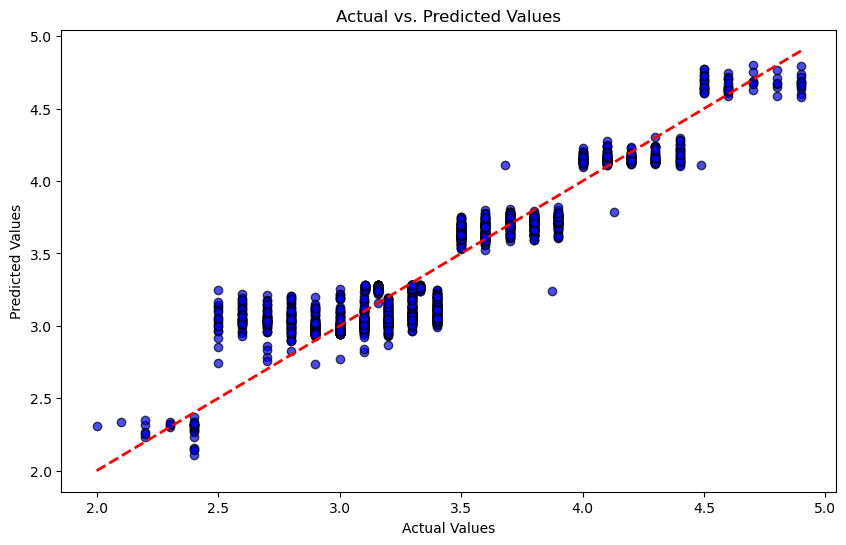

In [89]:
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = best_rf.predict(X_test_scaled)

# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', edgecolor='k', alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.show()

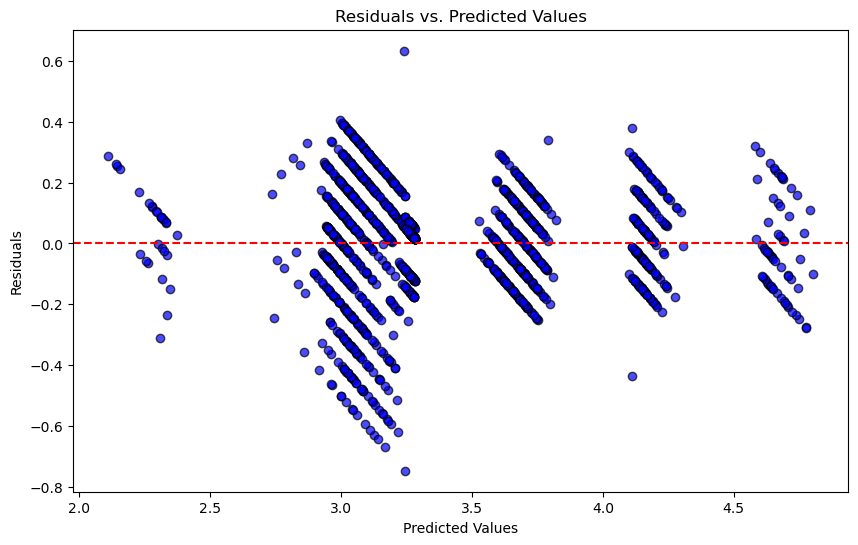

In [90]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', edgecolor='k', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()
